# Predicting Earnings Surprises

## Task

We want to predict the magnitude of company's upcoming earnings announcement using a machine learning classification model. The model is trained on three types of data: earnings, pricing, and technical price action data. The optimized model outputs a result into one of three classes: positive, neutral, or negative. A 'positive' classification indicates a predicted surprise >15% of the estimated eps, a 'negative' classification indicates a predicted surprise <-15% of the estimated eps, and a 'neutral' classification indicates no predicted surprise (15% < x < -15%). 

## Data

The data for training and testing the model came from several external data providers. Earning and pricing data was collected from Financial Modeling Prep's historical earnings calendar and daily indicator endpoints. Technical data is collected from FMP Cloud's daily technical indicator endpoint.

The schema below outlines the database architecture into an AWS RDS MySQL database:

![Untitled Workspace (1)](https://user-images.githubusercontent.com/45079557/150410944-eb8c8e30-ac2d-4f23-bb03-cb5c3f489cfb.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from decouple import config
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from scipy import stats

In [2]:
# Set parameters for AWS database
aws_hostname = config("AWS_HOST")
aws_database = config("AWS_DB")
aws_username = config("AWS_USER")
aws_password = config("AWS_PASS")
aws_port = config("AWS_PORT")

# Pull API keys from .env file
FMP_API_KEY = config("FMP_API_KEY")
FMP_CLOUD_API_KEY = config("FMP_CLOUD_API_KEY")

In [3]:
db = pymysql.connect(host=aws_hostname,user=aws_username, password=aws_password, database='rds-python', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
cursor = db.cursor()

### Retrieve Data from MySQL Database

In [4]:
cursor.execute("SELECT e.*, p.*, t.* FROM earnings e INNER JOIN pricing p ON e.id = p.id INNER JOIN technicals t ON e.id = t.id")
train = cursor.fetchall()

In [5]:
train_df = pd.DataFrame(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75781 entries, 0 to 75780
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75781 non-null  object 
 1   earnings_date      75781 non-null  object 
 2   symbol             75781 non-null  object 
 3   eps                75578 non-null  float64
 4   eps_estimated      75781 non-null  float64
 5   earnings_time      75781 non-null  object 
 6   p.id               75781 non-null  object 
 7   p.earnings_date    75781 non-null  object 
 8   p.symbol           75781 non-null  object 
 9   open_price         75781 non-null  float64
 10  high_price         75781 non-null  float64
 11  low_price          75781 non-null  float64
 12  close_price        75781 non-null  float64
 13  adj_close          75781 non-null  float64
 14  daily_volume       75781 non-null  int64  
 15  unadjusted_volume  75781 non-null  int64  
 16  change_dollars     757

In [6]:
cursor.close()
db.close()

### Cleaning Data

In [7]:
train_df = train_df.drop(['p.id', 'p.earnings_date', 'p.symbol', 't.id', 't.earnings_date', 't.symbol'], axis = 1)
print(train_df.head())

                id earnings_date symbol   eps  eps_estimated earnings_time  \
0   2012-01-09-AYI        1/9/12    AYI  0.74           0.67           bmo   
1   2012-01-09-HWM        1/9/12    HWM -0.09          -0.09           bmo   
2  2012-01-09-SCHN        1/9/12   SCHN  0.25           0.23           bmo   
3  2012-01-09-WDFC        1/9/12   WDFC  0.42           0.54           amc   
4   2012-01-10-SNX       1/10/12    SNX  1.37           1.14           amc   

   open_price  high_price  low_price  close_price  ...   sma_5  sma_10  \
0   54.980000   57.810001  52.250000    54.939999  ...  50.715  50.374   
1   20.824589   21.319340  20.734632    21.206898  ...   5.909   5.708   
2   42.770000   44.990002  42.750000    44.180000  ...  32.557  31.835   
3   40.290001   41.560001  39.840000    41.080002  ...  34.203  34.365   
4   15.895000   16.055000  15.800000    16.045000  ...  14.678  14.448   

   sma_20   ema_5  ema_10  ema_20  rsi_14   wma_5  wma_10  wma_20  
0  49.102  50.717 

In [8]:

is_NaN = train_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
forecast_these = train_df[row_has_NaN]
print(len(forecast_these))
print(forecast_these.head())

203
                    id earnings_date symbol  eps  eps_estimated earnings_time  \
75578   2022-01-18-BFC      01/18/22    BFC  NaN           1.39           bmo   
75579    2022-01-18-BK      01/18/22     BK  NaN           1.02           bmo   
75580  2022-01-18-CNXC      01/18/22   CNXC  NaN           2.54           amc   
75581  2022-01-18-CTXS      01/18/22   CTXS  NaN           0.43           bmo   
75582   2022-01-18-FBK      01/18/22    FBK  NaN           0.82           bmo   

       open_price  high_price  low_price  close_price  ...    sma_5   sma_10  \
75578       71.45      72.580      70.61        71.64  ...   72.376   72.432   
75579       63.20      63.690      62.16        63.60  ...   63.334   61.959   
75580      170.21     173.120     163.33       166.64  ...  169.310  172.466   
75581       94.53      96.260      94.45        95.80  ...   96.558   96.766   
75582       45.63      46.971      45.54        46.92  ...   46.406   45.870   

         sma_20       ema_5 

In [9]:
train_df = train_df[train_df["eps"].notna()]
df = train_df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75578 entries, 0 to 75577
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75578 non-null  object 
 1   earnings_date      75578 non-null  object 
 2   symbol             75578 non-null  object 
 3   eps                75578 non-null  float64
 4   eps_estimated      75578 non-null  float64
 5   earnings_time      75578 non-null  object 
 6   open_price         75578 non-null  float64
 7   high_price         75578 non-null  float64
 8   low_price          75578 non-null  float64
 9   close_price        75578 non-null  float64
 10  adj_close          75578 non-null  float64
 11  daily_volume       75578 non-null  int64  
 12  unadjusted_volume  75578 non-null  int64  
 13  change_dollars     75578 non-null  float64
 14  change_percent     75578 non-null  float64
 15  vwap               75578 non-null  float64
 16  change_over_time   755

### EDA/Feature Engineering

In [10]:
df["perc_diff"] = ((df["eps"] - df["eps_estimated"]) / df["eps"])
print(df["perc_diff"])

0         0.094595
1        -0.000000
2         0.080000
3        -0.285714
4         0.167883
           ...    
75573     0.120879
75574     0.727273
75575   -13.000000
75576     0.714286
75577    -1.250000
Name: perc_diff, Length: 75578, dtype: float64


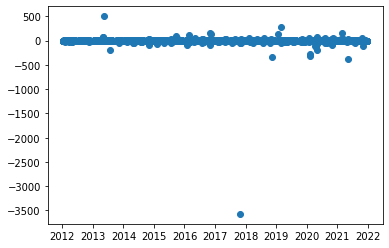

In [11]:
plt.scatter(pd.to_datetime(df["earnings_date"]), df["perc_diff"])
plt.show()

Few outliers are present in the percentage difference between EPS and EPS estimated. Therefore, we will fitler out rows that are greater than 3 or less than -3 standard deviations away.

In [24]:
df = df[df.perc_diff.between(df.perc_diff.quantile(.01), df.perc_diff.quantile(.99))]
print("Earnings Surprise Average: {}".format(df["perc_diff"].mean()))

Earnings Surprise Average: 0.09443734467171165


#### Distribution of Historical Earnings Surprises

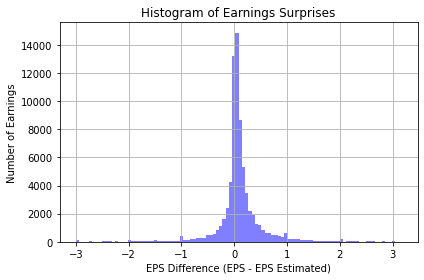

In [13]:
num_bins = 100
plt.hist(df["perc_diff"], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('EPS Difference (EPS - EPS Estimated)')
plt.ylabel('Number of Earnings')
plt.title('Histogram of Earnings Surprises')
plt.grid(True)
plt.tight_layout()
plt.savefig('visuals/histogram_eps_diff.png', facecolor='white', transparent=False)
plt.show()

After removing outliers, we can see that the majority of historical earnings follow a normal distribution around the mean of 9%.

#### Significant Earnings Surprise Breakdown

In [14]:
pos_surp = df[(df.perc_diff > .15)]
neg_surp = df[(df.perc_diff < -.15)]
neu_surp = df[(df.perc_diff < .15) & (df.perc_diff > -.15)]

x = ["Positive", "Neutral", "Negative"]
surprises = [len(pos_surp), len(neu_surp), len(neg_surp)]

print(len(pos_surp))
print("-------------")
print(len(neg_surp))
print("-------------")
print(len(neu_surp))

21684
-------------
8759
-------------
43505


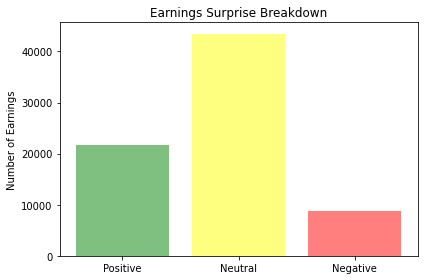

In [15]:
# Breakdown of the total number of each type of surprise in the dataset
# Positive: >15% surprise
# Neutral: <15% surprise and >-15% surprise
# Negative: <-15% surprise
plt.bar(x, surprises, color=['green', 'yellow', 'red'], alpha=0.5)
plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown')
plt.tight_layout()
plt.savefig('visuals/earn_bar.png', facecolor='white', transparent=False)
plt.show()

From the bar chart above, there are significantly more positive earnings surprises than negative earnings surprises. Therefore, it might be more lucrative, you only go long plays on earnings. 

#### Earnings Surprise Breakdown Based on Earnings Time

In [16]:
print(df["earnings_time"].unique())

['bmo' 'amc']


In [17]:
pos_bmo = df[(df.perc_diff > .15) & (df["earnings_time"] == 'bmo')]
pos_amc = df[(df.perc_diff > .15) & (df["earnings_time"] == 'amc')]
neu_bmo = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["earnings_time"] == 'bmo')]
neu_amc = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["earnings_time"] == 'amc')]
neg_bmo = df[(df.perc_diff < -.15) & (df["earnings_time"] == 'bmo')]
neg_amc = df[(df.perc_diff < -.15) & (df["earnings_time"] == 'amc')]

In [18]:
x = ["Positive", "Neutral", "Negative"]
surprises_bmo = [len(pos_bmo), len(neu_bmo), len(neg_bmo)]
surprises_amc = [len(pos_amc), len(neu_amc), len(neg_amc)]

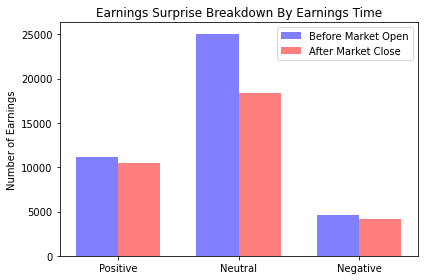

In [19]:
ind = np.arange(3) 
width = 0.35       
plt.bar(ind, surprises_bmo, width, label='Before Market Open', color='blue', alpha=0.5)
plt.bar(ind+width, surprises_amc, width,
    label='After Market Close', color='red', alpha=0.5)

plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown By Earnings Time')

plt.xticks(ind + width / 2, ('Positive', 'Neutral', 'Negative'))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('visuals/earn_bar_time.png', facecolor='white', transparent=False)
plt.show()


There is no significant difference between earnings surprise and when the earnings is announced (before market open or after market close).

#### Earnings Surprise Breakdown by Day of Week

In [20]:
# Need to find the date information using earnings date column
dates = pd.to_datetime(df["earnings_date"])
df["dow"] = dates.dt.dayofweek
print(df["dow"])


0        0
1        0
2        0
3        0
4        1
        ..
75572    2
75573    2
75574    3
75576    2
75577    3
Name: dow, Length: 74073, dtype: int64


/var/folders/fp/ky7t_b41243bb9937z642tf00000gn/T/ipykernel_14171/2254281529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dow"] = dates.dt.dayofweek


In [21]:
pos_m = df[(df.perc_diff > .15) & (df["dow"] == 0)]
pos_tu = df[(df.perc_diff > .15) & (df["dow"] == 1)]
pos_w = df[(df.perc_diff > .15) & (df["dow"] == 2)]
pos_th = df[(df.perc_diff > .15) & (df["dow"] == 3)]
pos_f = df[(df.perc_diff > .15) & (df["dow"] == 4)]

neu_m = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["dow"] == 0)]
neu_tu = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["dow"] == 1)]
neu_w = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["dow"] == 2)]
neu_th = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["dow"] == 3)]
neu_f = df[(df.perc_diff < .15) & (df.perc_diff > -.15) & (df["dow"] == 4)]

neg_m = df[(df.perc_diff < -.15) & (df["dow"] == 0)]
neg_tu = df[(df.perc_diff < -.15) & (df["dow"] == 1)]
neg_w = df[(df.perc_diff < -.15) & (df["dow"] == 2)]
neg_th = df[(df.perc_diff < -.15) & (df["dow"] == 3)]
neg_f = df[(df.perc_diff < -.15) & (df["dow"] == 4)]

In [22]:
x = ["Positive", "Neutral", "Negative"]
surprises_m = [len(pos_m), len(neu_m), len(neg_m)]
surprises_tu = [len(pos_tu), len(neu_tu), len(neg_tu)]
surprises_w = [len(pos_w), len(neu_w), len(neg_w)]
surprises_th = [len(pos_th), len(neu_th), len(neg_th)]
surprises_f = [len(pos_f), len(neu_f), len(neg_f)]

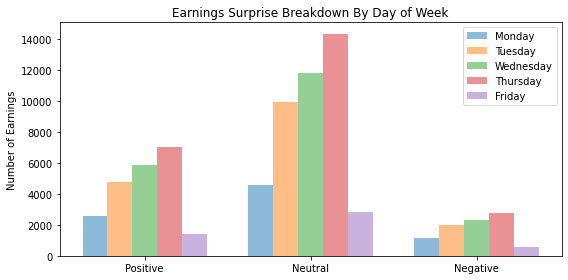

In [23]:
ind = np.arange(3) 
width = 0.15
plt.figure(figsize=(8, 4))
plt.bar(ind, surprises_m, width, label='Monday', alpha=0.5)
plt.bar(ind+width, surprises_tu, width, label='Tuesday', alpha=0.5)
plt.bar(ind+(2*width), surprises_w, width, label='Wednesday', alpha=0.5)
plt.bar(ind+(3*width), surprises_th, width, label='Thursday', alpha=0.5)
plt.bar(ind+(4*width), surprises_f, width, label='Friday', alpha=0.5)

plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown By Day of Week')

plt.xticks(ind + width*2, ('Positive', 'Neutral', 'Negative'))

plt.legend(loc='best')
plt.tight_layout()
plt.savefig('visuals/earn_bar_dow.png', facecolor='white', transparent=False)
plt.show()

### Feature Engineering